# **Import Libraries**

In [607]:
import os
import csv
import torch
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch.nn.functional as F
import torch.nn as nn
import seaborn as sns
%matplotlib inline

# **Transforming Data to Tensors**

In [562]:
DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/Emotion_Detect/new_Fer2013.csv'

In [563]:
data_df=pd.read_csv(DATA_DIR)
data_df.head()

,emotion,pixels,Usage,label
0,0,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training,Happy
1,0,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training,Happy
2,0,4 2 13 41 56 62 67 87 95 62 65 70 80 107 127 1...,Training,Happy
3,0,14 14 18 28 27 22 21 30 42 61 77 86 88 95 100 ...,Training,Happy
4,0,252 250 246 229 182 140 98 72 53 44 67 95 95 8...,Training,Happy


In [564]:
classes = ['Happy', 'Sad', 'Neutral']

In [565]:
class DataSet(torch.utils.data.Dataset):

    def __init__(self,transform=None, images=None, emotions=None):
        self.transform = transform
        self.images = images
        self.emotions = emotions

    def __getitem__(self, index):
        image = self.images[index]
        emotion = self.emotions[index]
        if self.transform is not None:
            image = self.transform(image)
        return image, emotion

    def __len__(self):
        return len(self.images)

In [566]:
class DataSetFactory:

    def __init__(self):
        images = list()
        emotions = list()
        val_images = list()
        val_emotions = list()
        test_images = list()
        test_emotions = list()

        with open(DATA_DIR, 'r') as file:
            data = csv.reader(file)
            next(data)
            for row in data:
                face = [int(pixel) for pixel in row[1].split()]
                face = np.asarray(face).reshape(48, 48)
                face = face.astype('uint8')

                if row[-2] == 'Training':
                    emotions.append(int(row[0]))
                    images.append(Image.fromarray(face))
                if row[-2] == "PrivateTest":
                    val_emotions.append(int(row[0]))
                    val_images.append(Image.fromarray(face))
                if row[-2]=="PublicTest":
                    test_emotions.append(int(row[0]))
                    test_images.append(Image.fromarray(face))
                

        print('training size %d : val size %d : test_size %d'%(len(images), len(val_images), len(test_images)))
        train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
        ])
        val_transform = transforms.Compose([
            transforms.ToTensor()
        ])

        self.training = DataSet(transform=train_transform, images=images, emotions=emotions)
        self.validation = DataSet(transform=val_transform, images=val_images, emotions=val_emotions)
        self.testing = DataSet(transform=val_transform, images=test_images, emotions=test_emotions)

In [567]:
train_tfms = transforms.Compose([
    transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

valid_tfms = transforms.Compose([
    transforms.ToTensor(), 
])

In [569]:
batch_size=128
factory = DataSetFactory()
training_loader = DataLoader(factory.training, batch_size=batch_size, shuffle=True, num_workers=2)
validation_loader = DataLoader(factory.validation, batch_size=batch_size, shuffle=True, num_workers=2)
testing_loader=DataLoader(factory.testing, batch_size=64, shuffle=True, num_workers=2)

training size 17010 : val size 2099 : test_size 2155


In [570]:
def decode_target(target, text_labels=False):
    result = list()
    if text_labels:
        result.append(classes[target] + "(" + str(target) + ")")
        return ' '.join(result)
    for i, x in enumerate(target):
        if (x == torch.max(target)):
          # result.append(classes[i] + "(" + str(i) + ")")
          # return ' '.join(result)
          return int(i)

In [571]:
def show_sample(img, target, predict = False):
    img=img.squeeze(0)
    if predict:
      return decode_target(target)
    else:
      print('Labels:',decode_target(target,text_labels=True))

In [572]:
if torch.cuda.is_available():
  device = torch.device('cuda')
device

device(type='cuda')

In [573]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [574]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [575]:
training_loader = DeviceDataLoader(training_loader, device)
validation_loader = DeviceDataLoader(validation_loader, device)
testing_loader = DeviceDataLoader(testing_loader, device)

# **Building Model CNN**

In [576]:
class Face(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}],last_lr: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch,result['lrs'][-1],result['val_loss'], result['val_acc']))

In [577]:
class SeparableConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, dilation, groups=in_channels,
                                   bias=bias)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1, 1, 0, 1, 1, bias=bias)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x


class ResidualBlock(nn.Module):

    def __init__(self, in_channeld, out_channels):
        super(ResidualBlock, self).__init__()

        self.residual_conv = nn.Conv2d(in_channels=in_channeld, out_channels=out_channels, kernel_size=1, stride=2,
                                       bias=False)
        self.residual_bn = nn.BatchNorm2d(out_channels, momentum=0.99, eps=1e-3)

        self.sepConv1 = SeparableConv2d(in_channels=in_channeld, out_channels=out_channels, kernel_size=3, bias=False,
                                        padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels, momentum=0.99, eps=1e-3)
        self.relu = nn.ReLU()

        self.sepConv2 = SeparableConv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, bias=False,
                                        padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels, momentum=0.99, eps=1e-3)
        self.maxp = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        res = self.residual_conv(x)
        res = self.residual_bn(res)
        x = self.sepConv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.sepConv2(x)
        x = self.bn2(x)
        x = self.maxp(x)
        return res + x


class FaceCnnModel(Face):

    def __init__(self):
        super(FaceCnnModel, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(8, affine=True, momentum=0.99, eps=1e-3)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, bias=False)
        self.bn2 = nn.BatchNorm2d(8, momentum=0.99, eps=1e-3)
        self.relu2 = nn.ReLU()

        self.module1 = ResidualBlock(in_channeld=8, out_channels=16)
        self.module2 = ResidualBlock(in_channeld=16, out_channels=32)
        self.module3 = ResidualBlock(in_channeld=32, out_channels=64)
        self.module4 = ResidualBlock(in_channeld=64, out_channels=128)

        self.last_conv = nn.Conv2d(in_channels=128, out_channels=7, kernel_size=3, padding=1)
        self.avgp = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, input):
        x = input
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.module1(x)
        x = self.module2(x)
        x = self.module3(x)
        x = self.module4(x)
        x = self.last_conv(x)
        x = self.avgp(x)
        x = x.view((x.shape[0], -1))
        return x

# **Training** **Model**

In [578]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [579]:
model = to_device(FaceCnnModel(), device)

In [580]:
max_lr=0.01
grad_clip = 0.1
weight_decay = 1e-4
epochs=10
opt_func = torch.optim.Adam

In [581]:
history = [evaluate(model, validation_loader)]


In [582]:
history += fit_one_cycle(epochs, max_lr, model, training_loader, validation_loader, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


Epoch [0],last_lr: 0.0028, val_loss: 0.8980, val_acc: 0.5700



Epoch [1],last_lr: 0.0076, val_loss: 0.7991, val_acc: 0.6394



Epoch [2],last_lr: 0.0100, val_loss: 0.6972, val_acc: 0.6778



Epoch [3],last_lr: 0.0095, val_loss: 0.6632, val_acc: 0.7049



Epoch [4],last_lr: 0.0081, val_loss: 0.6258, val_acc: 0.7281



Epoch [5],last_lr: 0.0061, val_loss: 0.5811, val_acc: 0.7371



Epoch [6],last_lr: 0.0039, val_loss: 0.5704, val_acc: 0.7527



Epoch [7],last_lr: 0.0019, val_loss: 0.5406, val_acc: 0.7663



Epoch [8],last_lr: 0.0005, val_loss: 0.5353, val_acc: 0.7695



Epoch [9],last_lr: 0.0000, val_loss: 0.5291, val_acc: 0.7780


# **Plotting and Comparisions**

In [583]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. Number. of epochs');

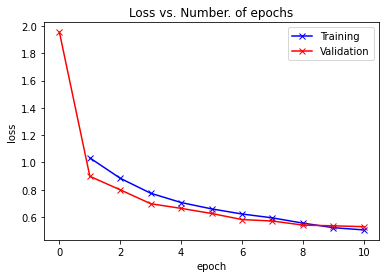

In [584]:
plot_losses(history)

In [585]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

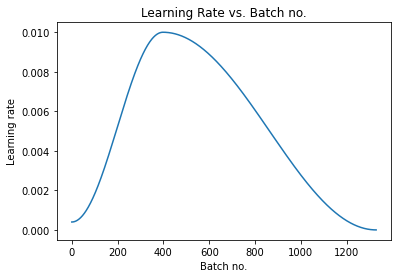

In [586]:
plot_lrs(history)

In [587]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

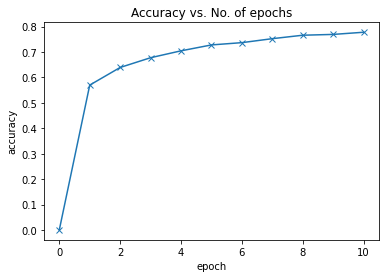

In [588]:
plot_accuracies(history)

In [589]:
def predict_single(image):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
#     test=torch.max(prediction)
#     # print(test)
#     index = prediction.cpu().data.numpy().argmax()
#     # print("Prediction: ", prediction)
    return show_sample(image, prediction, predict = True)

In [590]:
prediction_list = []
for i in range(len(factory.testing)):
  prediction_list.append(predict_single(factory.testing[i][0]) == int(factory.testing[i][1]))
  

Text(0.5, 1.0, 'Comparision of correct and wrong prediction')

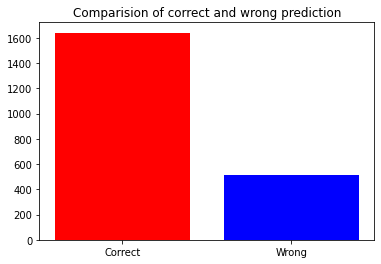

In [591]:
correct = prediction_list.count(True)
wrong = prediction_list.count(False)
height = [correct,wrong]
bars = ("Correct","Wrong")
x_pos = np.arange(len(bars))

# Create bars with different colors
plt.bar(x_pos, height, color=['red','blue'])

# Create names on the x-axis
plt.xticks(x_pos, bars)
plt.title("Comparision of correct and wrong prediction")
# Show graph

In [596]:
confusion_matrix = torch.zeros(3, 3)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(validation_loader):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[787.,  58.,  34.],
        [ 41., 422., 131.],
        [ 55., 152., 419.]])


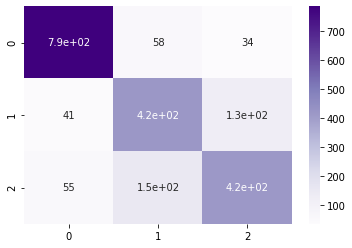

In [597]:
sn.heatmap(confusion_matrix,annot=True,cmap='Purples')

In [593]:
after = [evaluate(model, validation_loader)]
after

[{'val_acc': 0.7738339900970459, 'val_loss': 0.5342395901679993}]

In [601]:
accuracy = (confusion_matrix.diag()/confusion_matrix.sum(1))


[0.8953356146812439, 0.7104377150535583, 0.669329047203064]

Text(0.5, 1.0, 'Accuracy percentage prediction for each')

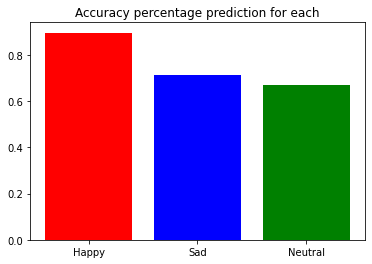

In [604]:
height = accuracy.tolist()
bars = ("Happy","Sad","Neutral")
x_pos = np.arange(len(bars))

# Create bars with different colors
plt.bar(x_pos, height, color=['red','blue',"green"])

# Create names on the x-axis
plt.xticks(x_pos, bars)
plt.title("Accuracy percentage prediction for each")
# Show graph

# **Saving Model**

In [605]:
torch.save(model,'Benten_CNN.pt')